# 1D finite difference wave propagation implemented using TensorFlow
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

## Summary
I implemented a simple (hard boundaries) 1D scalar wave equation propagator using finite differences with Google's [TensorFlow](https://www.tensorflow.org/) library. Although this provides the convenience of being able to write good performance code in Python, it is less flexible than a C or Fortran implementation, and doesn't run as fast.

## Introduction
TensorFlow is best known as a library for building and training deep neural networks, but it can also be used for other purposes. There is even an official example that uses Tensorflow to [solve a PDE](https://www.tensorflow.org/tutorials/pdes). I [previously](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb) explored a variety of ways of implementing a 1D finite difference scalar wave propagator (which solves the 1D scalar wave equation PDE) that is callable from Python. Since it is also possible to do this with TensorFlow, and I was curious about the performance, this is an extension of that work.

## Code
Here is a copy of [the code](https://github.com/ar4/wave_1d_fd_tf/blob/master/wave_1d_fd_tf/propagators.py) that implements the propagator using TensorFlow.

In [ ]:
class VTF(Propagator):
    """A TensorFlow implementation."""
    def __init__(self, model, dx, dt=None):
        super(VTF, self).__init__(model, dx, dt, npad=0)
        # Create a TensorFlow Session
        self.sess = tf.Session()

        # Save c(x)^2 * dt^2 as a constant Tensor
        self.model_padded2_dt2 = tf.constant(self.model_padded2_dt2)

        # Create placeholders that will hold:
        #   Two time steps of the wavefield
        self.f = tf.placeholder(tf.float32, shape=(self.nx_padded))
        self.fp = tf.placeholder(tf.float32, shape=(self.nx_padded))
        #   The source amplitude with time, and the source positions
        self.sources = tf.placeholder(tf.float32, shape=(None))
        self.sources_x = tf.placeholder(tf.int64, shape=(None))

        # Create the spatial finite difference kernel that will calculate
        # d^2/dx^2, reshape it into the appropriate shape for a 1D
        # convolution, and save it as a constant tensor
        fd_kernel = np.array([-735, +15360,
                              -156800, +1053696,
                              -5350800, +22830080,
                              -94174080, +538137600,
                              -924708642,
                              +538137600, -94174080,
                              +22830080, -5350800,
                              +1053696, -156800,
                              +15360, -735] / (302702400 * self.dx**2),
                              np.float32)
        fd_kernel = fd_kernel.reshape([-1, 1, 1])
        fd_kernel = tf.constant(fd_kernel)

        # Calculate d^2/dx^2 by convolving with the above kernel
        def laplace(x):
            return tf.squeeze(tf.nn.conv1d(tf.reshape(x, [1, -1, 1]), fd_kernel, 1, 'SAME'))

        # The main evolution equation:
        # f(t+1, x) = c(x)^2 * dt^2 * d^2(f(t, x))/dx^2 + 2f(t, x) - f(t-1, x)
        self.fp_ = self.model_padded2_dt2 * laplace(self.f) + 2*self.f - self.fp

        # Add the sources
        # f(t+1, x_s) += c(x_s)^2 * dt^2 * s(t)
        # To do this, we need to extract c(x)^2 * dt^2 at the locations of the
        # sources. I do this using tf.gather, and then create a new array that
        # contains the source amplitudes multiplied by the appropriate
        # c(x)^2 * dt^2
        sources_v = tf.gather(self.model_padded2_dt2, self.sources_x)
        sources_amp = self.sources * sources_v
        # We can then add this new array to f(t+1), but to do so we need to
        # expand it into the same size as f(t+1) (it currently contains
        # one element for each source, but we need it to contain one element
        # for each x), so we use tf.sparse_to_dense. This will create an array
        # of the right size, almost entirely filled with zeros, with the
        # source amplitudes in the right places.
        self.fp_ += tf.sparse_to_dense(self.sources_x, [self.nx_padded], sources_amp)

    def step(self, num_steps, sources=None, sources_x=None):
        """Propagate wavefield one time step."""

        # tf.sparse_to_dense requires that the indicies of the source positions
        # (sources_x) are in order, so we need to sort them (and thus also the
        # source amplitudes (sources))
        ssort = sources_x.argsort()
        sources_sort = sources[ssort, :]
        sources_x_sort = sources_x[ssort]

        for istep in range(num_steps):
            # Extract the source amplitudes for this step
            sources_step = sources_sort[:,istep]

            # Run the computational graph to get the wavefield at t+1.
            # We need to pass in values for the placeholders.
            y = self.sess.run(self.fp_, {self.sources: sources_step,
                                         self.sources_x: sources_x_sort,
                                         self.f: self.current_wavefield,
                                         self.fp: self.previous_wavefield})
            # Save the calculated wavefield
            self.previous_wavefield[:] = y[:]

            # Swap the wavefield pointers in preparation for the next time step
            tmp = self.current_wavefield
            self.current_wavefield = self.previous_wavefield
            self.previous_wavefield = tmp

        if num_steps > 0:
            return y
        else:
            return self.current_wavefield

## Ease of implementation
To perform computations in TensorFlow, you first construct a computation graph. This allows TensorFlow to create optimised code to implement the computation when the graph is defined. As the same computation is performed repeatedly to propagate a wave forward in time, this approach works well for the propagation application. I create this computation graph in propagator's `__init__` (see the code above), so it runs when the propagator is created. Although it looks like I am doing computations in `__init__`, this is only building the graph. The graph then gets executed in `step`, when I run the session and tell it that I want the value of `self.fp_`.

Some frustration arises, however, because of the limited operations that can be performed in TensorFlow. I assume these limitations exist because the library's primary purpose is for training neural networks and so it must be able to automatically differentiate every operation to enable [backpropagation](https://en.wikipedia.org/wiki/Backpropagation). The main one that I encountered in this project occurs when trying to add the sources to the wavefield. I want to add to just a few locations in the wavefield, where the sources are located. TensorFlow has a scatter_add function, which seems perfect, but it can only be used with Variables, whereas the wavefield is a Tensor. The work-around I employ is to use sparse_to_dense, which creates a dense array that is zero except at the locations of the sources. If the wavefield is large and the number of sources is small, this is rather wasteful (adding an array that is almost entirely zeros).

In [5]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Results
I ran the same tests as [previously](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb).

### Varying the number of time steps

version
TensorFlow    Axes(0.125,0.125;0.775x0.775)
dtype: object

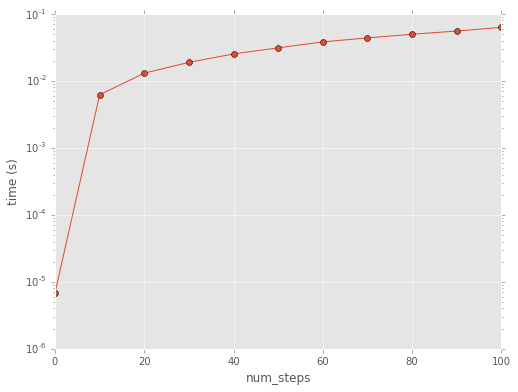

In [6]:
times = pd.read_csv('times_num_steps.csv')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_yscale('log')
ax.set_ylabel('time (s)')
times.groupby('version').plot(x='num_steps', y='time', ax=ax, style='o-', legend=False)

The TensorFlow implementation took about 0.06 s for 100 steps in this test. Although quite a bit faster than the Python+Numpy implementation in my previous results (which took around 7.5 s for 100 steps), it is still much slower than my previous C and Fortran implementations, which managed around 0.002 s for 100 steps.

### Varying the model size

version
TensorFlow    Axes(0.125,0.125;0.775x0.775)
dtype: object

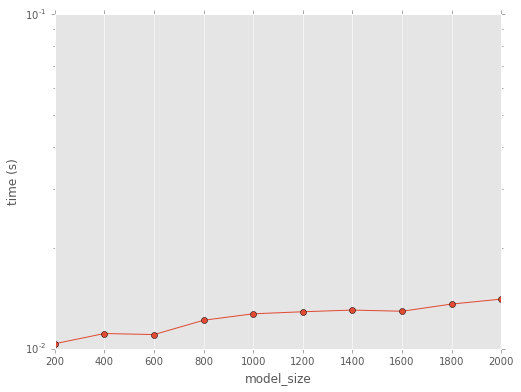

In [7]:
times = pd.read_csv('times_model_size.csv')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_yscale('log')
ax.set_ylabel('time (s)')
times.groupby('version').plot(x='model_size', y='time', ax=ax, style='o-', legend=False)

Logscale makes this plot look a bit strange, but I wanted it to be comparable with the plot in the previous notebook. The story is the same as above: 0.014 s for a 2000 cell model is better than Python (3 s), but worse than C/Fortran (0.0004 s).

## Conclusions
It's nice to be able to use TensorFlow for applications other than neural networks, and some aspects of development are a little bit easier than when using C/Fortran for the computationally intensive parts (no need to recompile), but the performance difference is large enough that for now I will stick with C/Fortran.